In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
from tqdm.notebook import tqdm

import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd()))

from berp.generators import thresholded_recognition
from berp.models.reindexing_regression import ModelParameters

In [62]:
item = thresholded_recognition.sample_item("In the episode, she learns that her then estranged husband is releasing a new song",
                                           recognition_threshold=torch.tensor(0.9))
X_word, X_phon, y = item[:3]

in the episode she learns that her then estranged husband is releasing a new song


In [63]:
X_word

,token,time,recognition_point,surprisal
token_idx,,,,
0,in,0.101562,0,12.007870
1,the,1.171875,0,12.988710
2,e,2.414062,2,12.580162
3,pis,3.062500,0,12.488288
4,o,4.546875,2,12.164897
5,de,5.523438,0,12.243136
6,she,6.906250,0,12.984801
7,le,8.218750,0,11.751792
8,ar,9.179688,2,12.114473


In [64]:
X_phon

time phoneme  surprisal
token_idx phon_idx                              
0         0          0.101562       i  13.577942
          1          0.289062       n  13.990884
1         0          1.171875       t  14.921688
          1          1.460938       h  14.967127
          2          1.726562       e  14.914088
2         0          2.414062       e  14.505540
3         0          3.062500       p  14.579939
          1          3.335938       i  14.058360
          2          3.554688       s  14.474984
4         0          4.546875       o  14.187744
5         0          5.523438       d  14.261079
          1          5.828125       e  14.168514
6         0          6.906250       s  14.971498
          1          7.250000       h  14.963219
          2          7.601562       e  14.910179
7         0          8.218750       l  13.859015
          1          8.476562       e  13.677169
8         0          9.179688       a  14.069689
          1          9.312500       r  14.196880
9         0          9.945312       n  14.195697
          1         10.195312       s  14.199380
10        0         10.867188       t  14.723595
          1         11.062500       h  14.769033
          2         11.218750       a  14.745832
          3         11.382812       t  14.723595
11        0         12.390625       h  14.325828
          1         12.546875       e  14.272788
          2         12.796875       r  14.429817
12        0         13.585938       t  14.979219
          1         13.828125       h  15.024659
          2         14.054688       e  14.971620
13        0         14.953125       n  13.775146
14        0         15.992188       e  13.678377
          1         16.195312       s  13.739697
          2         16.492188       t  13.685978
15        0         17.437500       r  13.619568
16        0         18.226562       a  15.045688
          1         18.445312       n  15.073485
          2         18.554688       g  14.857826
17        0         19.335938       e  14.767882
          1         19.648438       d  14.860447
18        0         20.421875       s  15.004490

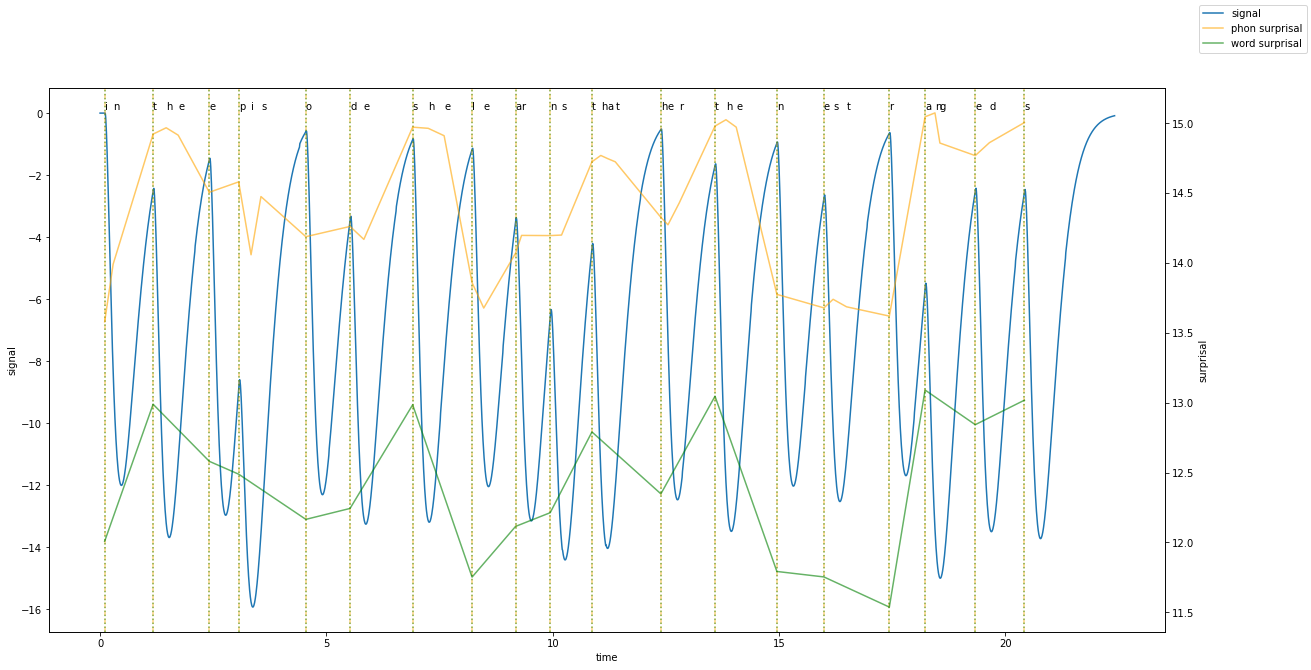

In [65]:
plt.subplots(figsize=(20, 10))
ax = sns.lineplot(data=y, x="time", y="signal")
twinx = ax.twinx()
sns.lineplot(data=X_phon, x="time", y="surprisal", color="orange", alpha=0.6, ax=twinx)
sns.lineplot(data=X_word, x="time", y="surprisal", color="green", alpha=0.6, ax=twinx)
ax.figure.legend(["signal", "phon surprisal", "word surprisal"])

word_onsets = X_phon.groupby("token_idx").apply(lambda xs: xs.iloc[0]).time
for _, phon in X_phon.iterrows():
    ax.annotate(phon.phoneme, xy=(phon.time, 0.1))
for onset in word_onsets:
    ax.axvline(onset, linestyle="--", color="orange", alpha=0.5)
for recognition_onset in X_word.time:
    ax.axvline(recognition_onset, linestyle=":", color="green", alpha=0.5)

## Generate whole dataset

In [87]:
sys.path.append("scripts")
import regression_reindexing_synth as synth
sentences = synth.generate_sentences()

In [88]:
dataset = thresholded_recognition.sample_dataset(sentences)

  0%|          | 0/22 [00:00<?, ?it/s]

alice was beginning to get very tired of sitting by her sister on the bank and of having nothing to do once or twice she had peeped into the book her sister was reading but it had no pictures or conversations in it and what is the use of a book thought alice without pictures or conversation
so she was considering in her own mind as well as she could for the hot day made her feel very sleepy and stupid whether the pleasure of making a daisychain would be worth the trouble of getting up and picking the daisies when suddenly a white rabbit with pink eyes ran close by her
there was nothing so very remarkable in that nor did alice think it so very much out of the way to hear the rabbit say to itself oh dear
oh dear
i shall be late
when she thought it over afterwards it occurred to her that she ought to have wondered at this but at the time it all seemed quite natural but when the rabbit actually took a watch out of its waistcoatpocket and looked at it and then hurried on alice started to he

In [89]:
epochs = thresholded_recognition.dataset_to_epochs(dataset.X_word, dataset.y)

  0%|          | 0/292 [00:00<?, ?it/s]

In [90]:
baseline_window = (-.1, 0)
test_window = (0.3, 0.5)
df_test = epochs.groupby(["item", "token_idx"]).apply(
    lambda rows: pd.Series({"epoch_baseline": rows[(rows.epoch_time >= baseline_window[0]) & (rows.epoch_time < baseline_window[1])].signal.mean(),
                            "epoch_value": rows[(rows.epoch_time >= test_window[0]) & (rows.epoch_time < test_window[1])].signal.mean()}))

In [91]:
merged_df = pd.merge(df_test, dataset.X_word, left_index=True, right_index=True)
merged_df["epoch_value_baselined"] = merged_df.epoch_value - merged_df.epoch_baseline

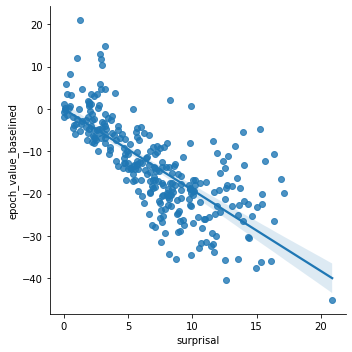

In [92]:
sns.lmplot(data=merged_df, x="surprisal", y="epoch_value_baselined")